# ARIMA vs Random Forest Regression 

Autoregressive Integrated Moving Averages
The general process for ARIMA models is the following:

Visualize the Time Series Data

Make the time series data stationary

Plot the Correlation and AutoCorrelation Charts

Construct the ARIMA Model or Seasonal ARIMA based on the data

Use the model to make predictions

In [128]:
#Importing the necessary libarries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
#Reading the data file with pandas library
df=pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [130]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [131]:
df.columns=["Month","Sales"]
## Drop last 2 rows
df.drop(106,axis=0,inplace=True)
df.drop(105,axis=0,inplace=True)
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [132]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


# Step 2: Visualizing the Data

<AxesSubplot:xlabel='Month'>

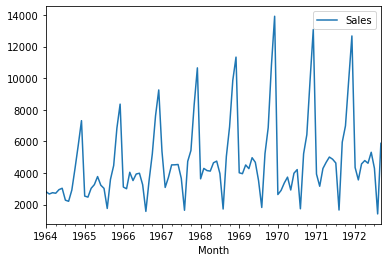

In [133]:
df.plot()

In [134]:
### Testing For Stationarity using Dicky fuller test

from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Sales'])
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(df['Sales'])


ADF Test Statistic : -1.8335930563276228
p-value : 0.363915771660245
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# As the Data is non stationary, differencing method is used to make it stationary

In [135]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)
df.head(14)

,Sales,Seasonal First Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
1964-06-01,3036.0,NaN
1964-07-01,2282.0,NaN
1964-08-01,2212.0,NaN
1964-09-01,2922.0,NaN


In [136]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


# The data is stationary now. 

<AxesSubplot:xlabel='Month'>

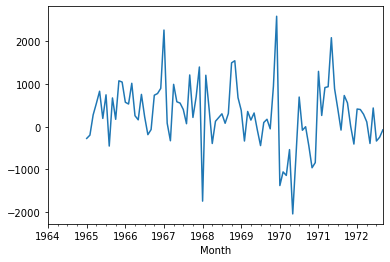

In [137]:
df['Seasonal First Difference'].plot()

Final Thoughts on Autocorrelation and Partial Autocorrelation
Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. 
The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, 
the number of non-zero partial autocorrelations gives the order of the AR model.
By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. 
A clearer pattern for an MA model is in the ACF. 
The ACF will have non-zero autocorrelations only at lags involved in the model.
p,d,q p AR model lags d differencing q MA lags



In [138]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

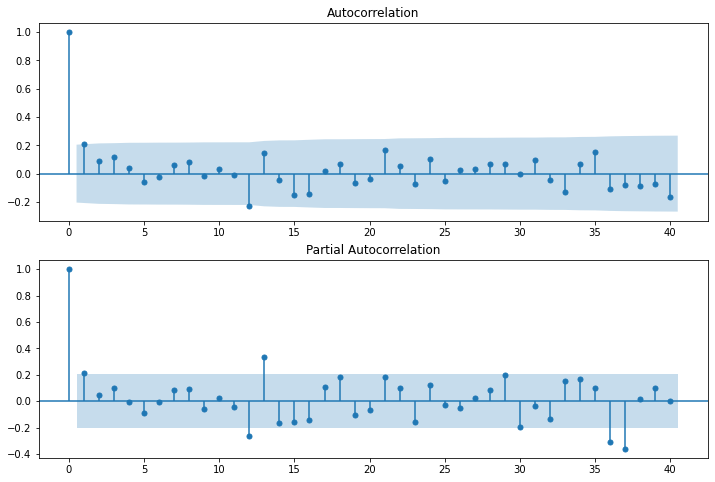

In [139]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [140]:
# For non-seasonal data the value of p, d, q  are interpreted by the ACF and PACF plots
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\Comp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Comp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


# Seasonal ARIMA is used for forecasting

<AxesSubplot:xlabel='Month'>

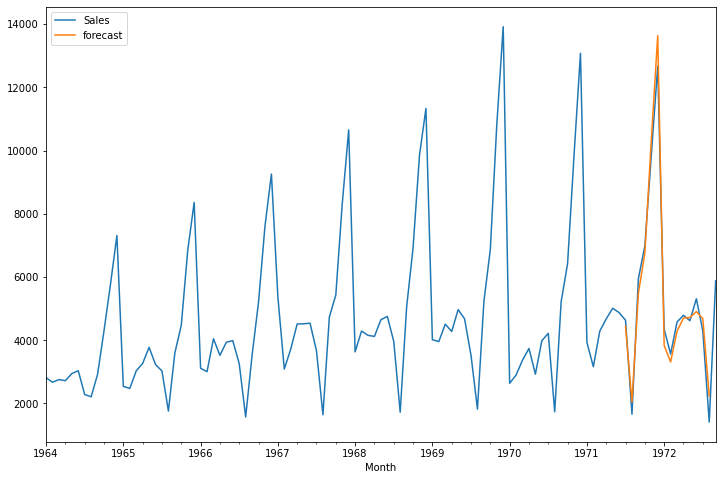

In [141]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

<AxesSubplot:>

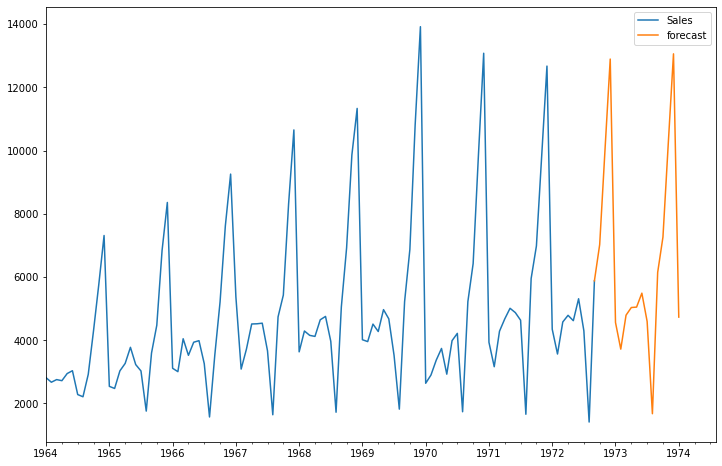

In [142]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df=pd.concat([df,future_datest_df])
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 

In [143]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Sat, 11 Dec 2021   AIC                           1910.251
Time:                        21:21:21   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7835     12.405      1.837      0.066      -1.530      47.097
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [144]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [145]:
rmse(df['Sales'].iloc[90:103], df['forecast'].iloc[90:103])

425.3321405293599

# Random Forest Regression model

In [149]:
#Reading the data file with pandas library
df=pd.read_csv('perrin-freres-monthly-champagne-.csv')
df.columns=["Month","Sales"]
df = df.drop('Month',axis=1)
df.drop(106,axis=0,inplace=True)
df.drop(105,axis=0,inplace=True)
df['Sale_LastMonth']=df['Sales'].shift(+1)
df['Sale_2Monthsback']=df['Sales'].shift(+2)
df['Sale_3Monthsback']=df['Sales'].shift(+3)
df=df.dropna()
import numpy as np
x1,x2,x3,y=df['Sale_LastMonth'],df['Sale_2Monthsback'],df['Sale_3Monthsback'],df['Sales']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_x, y, test_size=0.10)



<ipython-input-152-2e7d67a978de>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


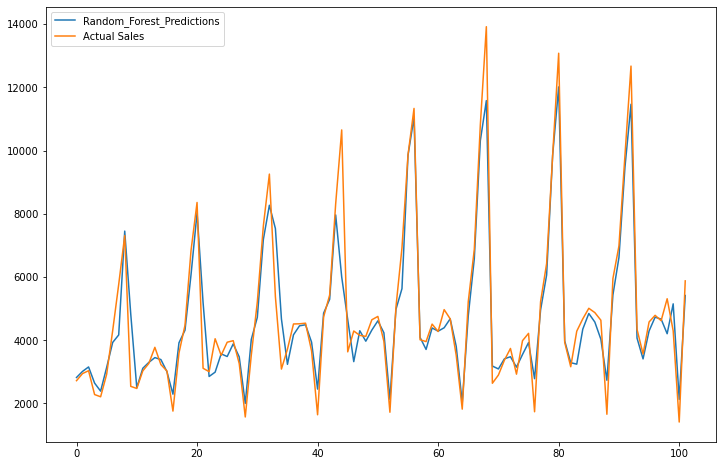

In [152]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=4)
model.fit(X_train, y_train)
pred=model.predict(final_x)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

In [153]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_rf=sqrt(mean_squared_error(pred,y))
print('Mean Squared Error for Random Forest Regression Model is:',rmse_rf)

Mean Squared Error for Random Forest Regression Model is: 819.4990103350925
